<a href="https://colab.research.google.com/github/jefftrojan/transfer_learning_formative/blob/main/Transfer_Learning_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MACHINE LEARNING TECHNIQUES - TRANSFER LEARNING ASSIGNMENT

### Name: Jeffrey Dauda
### Year/Intake: May 2022
### Mission area: Education

## Objective:
<b>The objective of this assignment is to apply transfer learning techniques for mission-related tasks as per the previous trimester summative from the ML pipeline. Apply transfer learning on the dataset related to your mission.

You will be leveraging pre-trained models and fine-tuning them for mission-specific tasks, which can significantly reduce training time and improve performance.
Assignment Tasks:

Preferably, find an Image dataset related to your mission.
Select at least three pre-trained models relevant to your chosen problem domain.
Justify your choice of pre-trained models based on their performance, architecture, and suitability for the task.
Implement fine-tuning techniques to adapt the selected pre-trained models to your specific task.
Describe the process of fine-tuning, including the layers modified and the rationale behind these modifications.</b>

## Dataset source:
- iam-handwritten-forms-dataset [https://paperswithcode.com/dataset/iam]

Models:

ResNet50
VGG16
MobileNetV2
# New Section

In [ ]:

import os
import glob
import random

import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tqdm.notebook as tqdm

%matplotlib inline
tqdm.tqdm.pandas()

# %pip install keras-ocr
# import keras_ocr
# detector = keras_ocr.detection.Detector()




In [ ]:
images = sorted(glob.glob('../input/iam-handwritten-forms-dataset/data/*/*.png'))


## **Preprocessing**

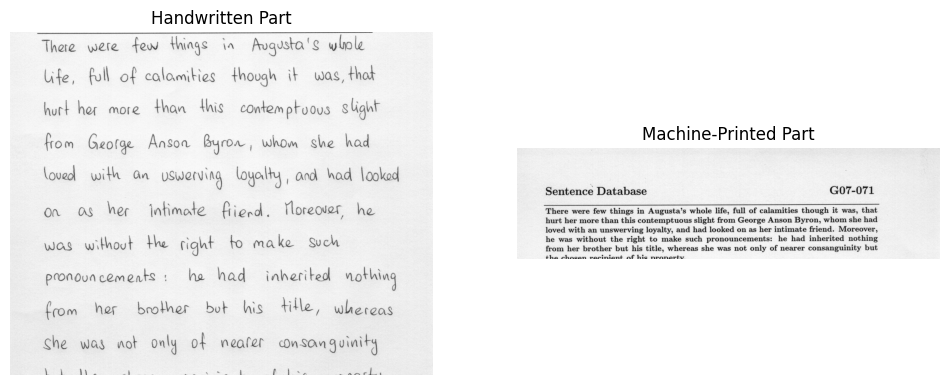

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import glob

# Assuming 'images' is a list of image file paths
images = sorted(glob.glob('../input/iam-handwritten-forms-dataset/data/*/*.png'))

def crop_and_split(img):
    if isinstance(img, str):
        img = cv2.imread(img)
        assert img is not None

    img = img[:, 200:]

    prt = img[:600]
    hand = img[650:2500]
    return hand, prt

# Select a random image
img_path = random.choice(images)
img = cv2.imread(img_path)

# Apply crop and split
hand, prt = crop_and_split(img)

# Display the images
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.imshow(cv2.cvtColor(hand, cv2.COLOR_BGR2RGB))  # Convert to RGB for display
ax1.set_title('Handwritten Part')
ax1.axis('off')

ax2.imshow(cv2.cvtColor(prt, cv2.COLOR_BGR2RGB))  # Convert to RGB for display
ax2.set_title('Machine-Printed Part')
ax2.axis('off')

plt.show()
plt.close()


<b>Next we convert the hand image from color to grayscale and applies a binary threshold to it. The thresholding helps in separating the text from the background by converting the image into a binary format (i.e black and white). The contours of the text regions are then detected.<b>


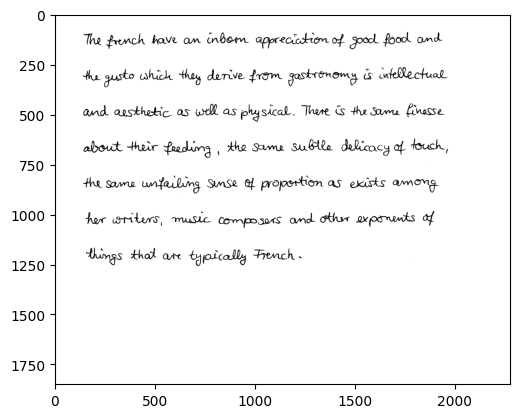

In [ ]:
hand = cv2.cvtColor(hand, cv2.COLOR_BGR2GRAY)
_, th = cv2.threshold(hand, 0, 255 , cv2.THRESH_BINARY + cv2.THRESH_OTSU)
contours, _ = cv2.findContours(th, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
chars = cv2.drawContours(np.zeros(hand.shape, dtype='uint8'), contours, -1, (1), -1)
plt.imshow(chars, cmap='gray')
plt.show()
plt.close()


<b> We create functions to process the images to detect and extract text regions, both printed and handwritten. It uses functions to split images into text blocks, reorder bounding box coordinates, and extract text lines by applying various image processing techniques. The pipeline includes warping and straightening text regions to ensure accurate extraction. Finally, it filters out unwanted text regions based on size and aspect ratio</b>

In [ ]:
from scipy.spatial.distance import cdist


def crop_textblocks(images, detector):
    hands, prts = zip(*[crop_and_split(img) for img in images])
    hands = [keras_ocr.tools.warpBox(img, box) for (img, boxes) in zip(hands, detector.detect(hands)) for box in boxes]
    prts = [keras_ocr.tools.warpBox(img, box) for (img, boxes) in zip(prts, detector.detect(prts)) for box in boxes]
    crops = prts + hands
    labels = ['prt' for _ in prts] + ['hand' for _ in hands]
    return crops, labels


def order_points(pts):
    """https://www.pyimagesearch.com/2016/03/21/ordering-coordinates-clockwise-with-python-and-opencv/"""
    x = pts[np.argsort(pts[:, 0]), :]

    left = x[:2, :]
    right = x[2:, :]

    left = left[np.argsort(left[:, 1]), :]
    (tl, bl) = left

    d = cdist(tl[np.newaxis], right, "euclidean")[0]
    (br, tr) = right[np.argsort(d)[::-1], :]
    return np.array([tl, tr, br, bl], dtype="float32")


def find_chars(img):
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    _, th = cv2.threshold(img, 0, 255 , cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(th, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    contours = [c[:, 0, :] for c in contours]
    return contours


def crop_min_area_rect(rect, img):
    box = cv2.boxPoints(rect)
    box = np.int0(box)

    # Reorder points to [tl, tr, br, bl]
    box = order_points(box).astype("float32")
    w = int(np.linalg.norm(box[0] - box[1]))
    h = int(np.linalg.norm(box[0] - box[3]))

    dst_pts = np.array([
        [0, 0], [w-1, 0], [w-1, h-1], [0, h-1]], dtype="float32")

    M = cv2.getPerspectiveTransform(box, dst_pts)

    # directly warp the rotated rectangle to get the straightened rectangle
    warped = cv2.warpPerspective(img, M, (w, h))
    return warped


def extract_lines(img, warp_crop=False, padx=4, pady=4):
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Finding text lines
    blur = cv2.GaussianBlur(img, (3, 3), 0)
    _, th = cv2.threshold(blur, 0, 255 , cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    block_kern_shape = (100, 1)
    block_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, block_kern_shape)
    dilation = cv2.dilate(th, block_kernel, iterations=1)
    contours, _ = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    crops, chars, bboxes = [], [], []
    for ctr in contours:
        box = cv2.boundingRect(ctr)
        if warp_crop:
            rect = cv2.minAreaRect(ctr)
            crop = crop_min_area_rect(rect, img)
            if is_unwanted(crop.shape[0], crop.shape[1]):
                continue
        else:
            x, y, w, h = box
            if is_unwanted(h, w):
                continue
            crop = img[y-pady:y+h+pady, x-padx:x+w+padx]

        char = find_chars(crop)
        if len(char) < 3:
            continue

        crops.append(crop)
        chars.append(char)
        bboxes.append(box)

    # crops, chars, bboxes = filter_crops(crops, chars, bboxes)
    return crops, chars, bboxes


def is_unwanted(h, w):
    return any([h < 10, w < 200, w/h < 1, w/h > 100])



<b>visualize extracted text regions by displaying cropped areas, contours, and bounding boxes from an image, and overlays these detected regions on the original image.<b>






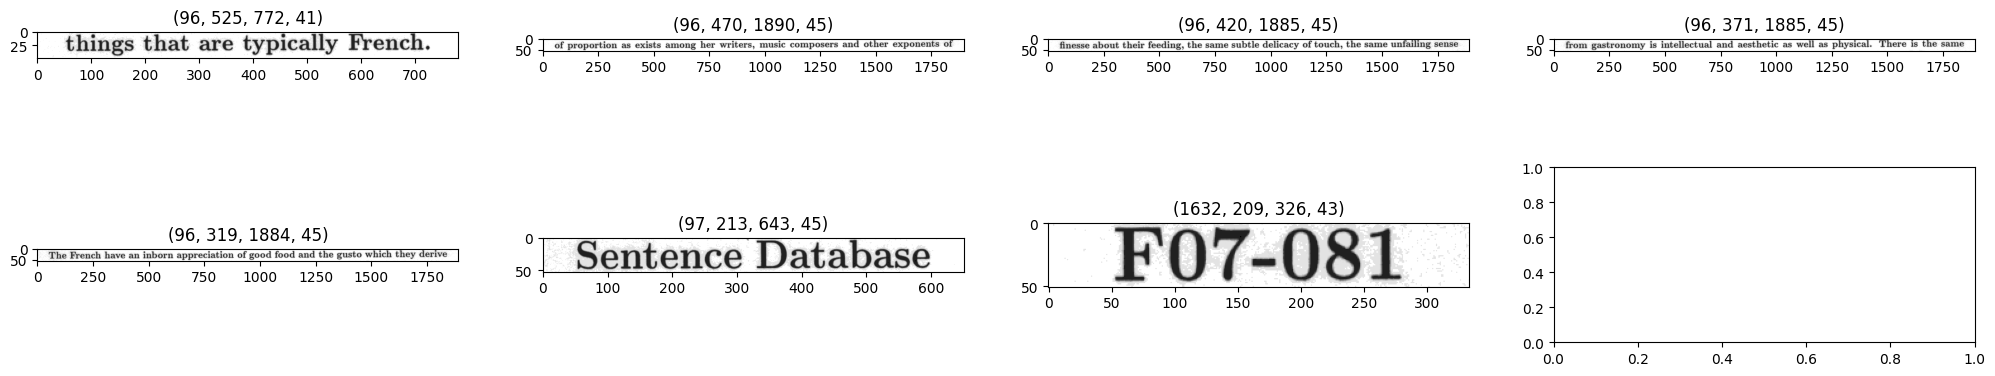

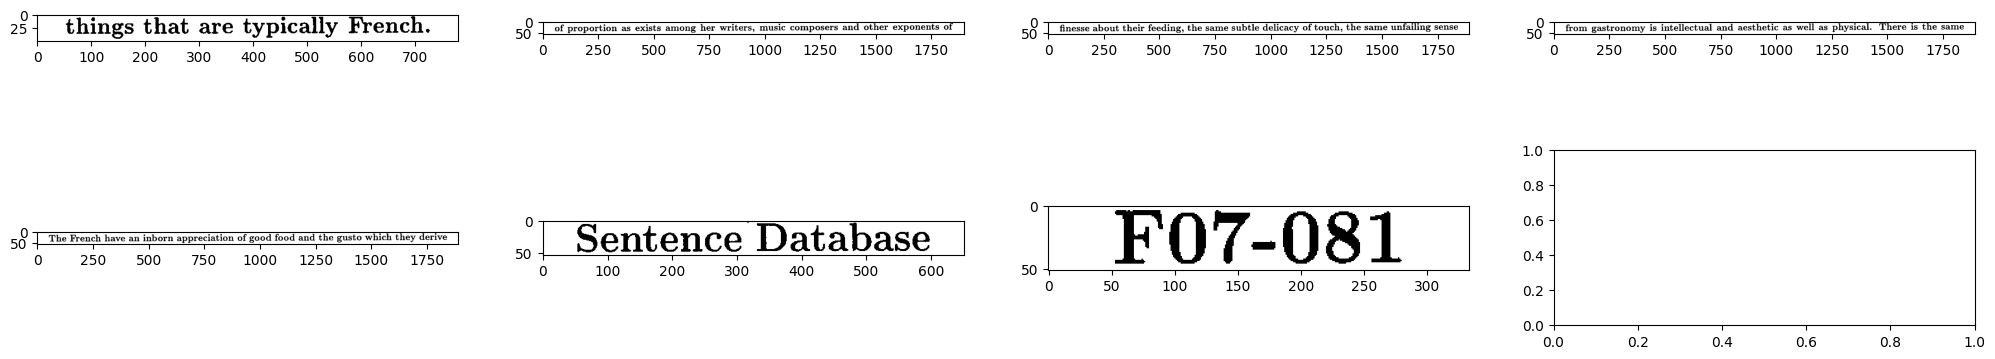

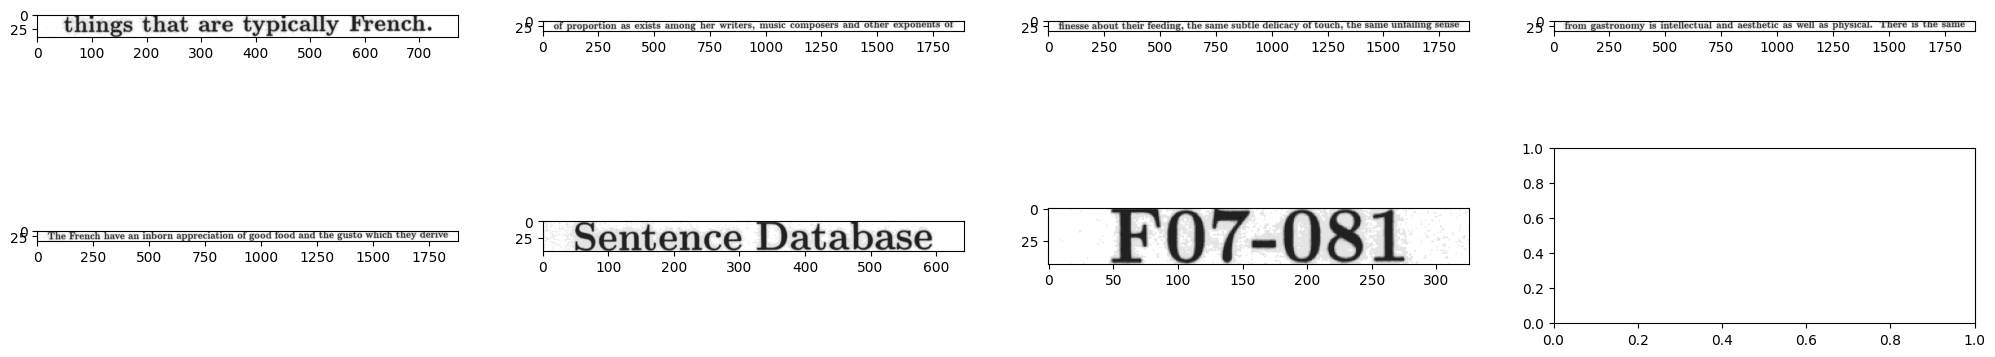

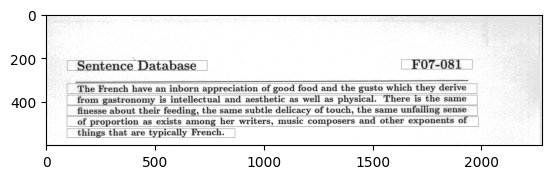

In [ ]:
img = prt.copy()
crops, contours, bboxes = extract_lines(img)

k = int(np.ceil(len(crops) / 4))
_, axs = plt.subplots(k, 4, figsize=(25, 5))
for crop, box, ax in zip(crops, bboxes, axs.flatten()):
    ax.imshow(crop, cmap='gray', vmin=0, vmax=255)
    ax.set_title(box)

plt.show()

_, axs = plt.subplots(k, 4, figsize=(25, 5))
for crop, ctrs, ax in zip(crops, contours, axs.flatten()):
    _img = cv2.drawContours(np.zeros(crop.shape[:2], dtype='uint8'), ctrs, -1, (255), -1)
    ax.imshow(_img, cmap='gray', vmin=0, vmax=255)

plt.show()

_, axs = plt.subplots(k, 4, figsize=(25, 5))
for box, ax in zip(bboxes, axs.flatten()):
    x, y, w, h = box
    ax.imshow(img[y:y+h, x:x+w])

plt.show()

_img = img.copy()
for (x, y, w, h) in bboxes:
    _img = cv2.rectangle(_img, (x, y), (x+w, y+h), 2)
plt.imshow(_img)
plt.show()

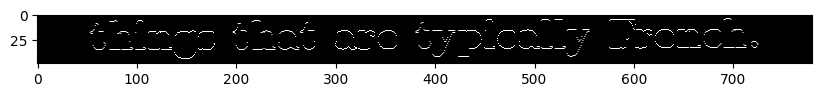

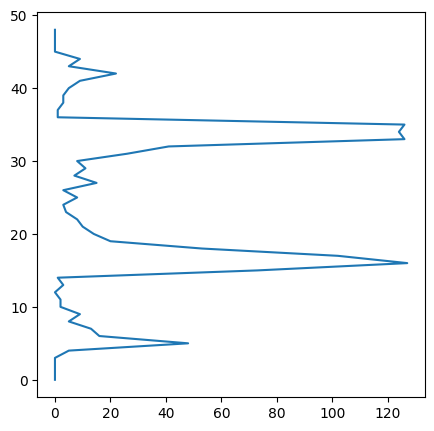

In [ ]:
def compute_ulp(img, contours):
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    h, w = img.shape

    chars = cv2.drawContours(np.zeros(img.shape, dtype='uint8'), contours, -1, (1), -1)
    mask = chars == 0

    ulp = []
    for i in range(w):
        y = np.zeros(h, dtype='uint8')
        m = mask[:, i]
        if m.any():
            idxs = np.arange(0, h)
            y[idxs[m].max()] = 1
            y[idxs[m].min()] = 1
        ulp.append(y)

    ulp = np.array(ulp).T
    return ulp

plt.figure(figsize=(10, 2))
ulp = compute_ulp(crops[0], contours[0])
plt.imshow(ulp, cmap='gray', vmin=0, vmax=1)
plt.show()

plt.figure(figsize=(5, 5))
hist = ulp.sum(axis=1)
plt.plot(hist, np.arange(0, len(hist)))
plt.show()
plt.close()

In [ ]:
def get_peak_idxs(hist):
    midpoint_idx = int(round(len(hist) / 2))

    lower_hist = hist[:midpoint_idx]
    lower_peak_val = lower_hist.max()
    lower_peak_idx = np.where(lower_hist == lower_peak_val)[0].min()

    upper_hist = hist[midpoint_idx:]
    upper_peak_val = upper_hist.max()
    upper_peak_idx = np.where(upper_hist == upper_peak_val)[0].max() + midpoint_idx

    assert upper_peak_idx > lower_peak_idx
    return lower_peak_idx, upper_peak_idx


def extract_features(hist):
    hist = hist.astype('float32')
    lower_peak_idx, upper_peak_idx = get_peak_idxs(hist)
    ascender_w = len(hist) - upper_peak_idx
    desender_w = lower_peak_idx
    main_body_w = upper_peak_idx - lower_peak_idx

    f_i = ascender_w / main_body_w
    f_ii = desender_w / main_body_w

    _max = hist.max()
    f_iii = hist.sum() / _max if _max > 0 else 0
    return [f_i, f_ii, f_iii]


In [ ]:
def process_crop(crop, chars):
    ulp = compute_ulp(crop, chars)
    hist = ulp.sum(axis=1)
    features = extract_features(hist)
    return features


def process_file(path):
    hand, prt = crop_and_split(path)

    features, labels = [], []

    crops, chars, _ = extract_lines(hand)
    for crop, ctrs in zip(crops, chars):
        features.append(process_crop(crop, ctrs))
        labels.append("hand")

    crops, chars, _ = extract_lines(prt)
    for crop, ctrs in zip(crops, chars):
        features.append(process_crop(crop, ctrs))
        labels.append("prt")

    return features, labels


features, labels = [], []
for img in tqdm.tqdm(images):
    f, l = process_file(img)
    features += f
    labels += l

features = np.array(features)
labels = np.array(labels)

  0%|          | 0/1539 [00:00<?, ?it/s]

# **Model**

Use RandomUnderSampler to balance classes by undersampling, StandardScaler for feature scaling, and LogisticRegressionCV with balanced class weights for classification

In [ ]:
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegressionCV as LRCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


x = features.copy()
y = labels.copy()

label_encoder = LabelEncoder().fit(y)
y = label_encoder.transform(y)

x_train, x_test, y_train, y_test = train_test_split(x, y, shuffle=True, test_size=0.2, stratify=y)

pipe = Pipeline([
    ('rus', RandomUnderSampler(random_state=0)),
    ('scaler', StandardScaler()),
    # ('sampler', SMOTE(random_state=0)),
    ('clf', LRCV(random_state=0, class_weight='balanced')),
]).fit(x_train, y_train)

print(classification_report(
    y_pred=pipe.predict(x_train), y_true=y_train, labels=label_encoder.transform(label_encoder.classes_), target_names=label_encoder.classes_))


              precision    recall  f1-score   support

        hand       0.96      0.92      0.94     14229
         prt       0.88      0.93      0.90      8390

    accuracy                           0.93     22619
   macro avg       0.92      0.93      0.92     22619
weighted avg       0.93      0.93      0.93     22619



In [12]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, VGG16, MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

# Load the models
def load_pretrained_model(model_name, input_shape=(224, 224, 3), num_classes=2):
    if model_name == "resnet50":
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    elif model_name == "vgg16":
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    elif model_name == "mobilenetv2":
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    else:
        raise ValueError("Model name not recognized")

    # Fine-tuning: add custom layers on top
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze the base model layers during initial training
    for layer in base_model.layers:
        layer.trainable = False

    return model

# Load three models
resnet50_model = load_pretrained_model("resnet50")
vgg16_model = load_pretrained_model("vgg16")
mobilenetv2_model = load_pretrained_model("mobilenetv2")

# Compile models
for model in [resnet50_model, vgg16_model, mobilenetv2_model]:
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Resize images to 224x224 (to fit pre-trained models input sizes)
def preprocess_image(img):
    return cv2.resize(img, (224, 224))

# Preprocess the dataset (images already loaded in `images`)
X = [preprocess_image(cv2.imread(img_path)) for img_path in images]
X = np.array(X)
X = X / 255.0  # Normalize

# Encode labels
label_encoder = LabelEncoder().fit(labels)
y = label_encoder.transform(labels)
y = to_categorical(y, 2)  # One-hot encoding for 2 classes

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [ ]:
# Fine-tune the models
def fine_tune_model(model, epochs, X_train, y_train, X_test, y_test):
    # Unfreeze the layers for fine-tuning
    for layer in model.layers:
        layer.trainable = True

    # Recompile with lower learning rate for fine-tuning
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

    # Train model
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=32)

    return history

# Fine-tune each model for 10 epochs
fine_tune_model(resnet50_model, epochs=10, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
fine_tune_model(vgg16_model, epochs=10, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
fine_tune_model(mobilenetv2_model, epochs=10, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)


In [ ]:
# Evaluate the models on the test set
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # Print classification report
    print(classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))

# Evaluate ResNet50
print("ResNet50 Performance:")
evaluate_model(resnet50_model, X_test, y_test)

# Evaluate VGG16
print("VGG16 Performance:")
evaluate_model(vgg16_model, X_test, y_test)

# Evaluate MobileNetV2
print("MobileNetV2 Performance:")
evaluate_model(mobilenetv2_model, X_test, y_test)


In [ ]:
# Plot accuracy and loss for each model
def plot_history(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{model_name} - Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'{model_name} - Training and Validation Loss')
    plt.show()

# Plot for each model
plot_history(resnet50_model.history, 'ResNet50')
plot_history(vgg16_model.history, 'VGG16')
plot_history(mobilenetv2_model.history, 'MobileNetV2')
